# Boxplot on AssessmentScore data, overlay w dots
I need a **plot** to summarize the assessment score data.
Plots may be built with
[matplotlib](https://realpython.com/python-matplotlib-guide/)
elements in Python.
[MatLibPlot documentation](https://matplotlib.org/).

Deploying `matlibplot` classes **as if they were within a Django project**
is made tricky demanding that the environment in which Django *apps* live
has a namespace that is initiated using (only?) the Django project's `settings.py`.

In this notebook, I experiment my way into 
[functional programming](https://en.wikipedia.org/wiki/Functional_programming)
with the mires of scope, name spacing,
[passing by value or by reference](https://www.python-course.eu/passing_arguments.php),
mutable and immutable objects.
Did I mention that plots will be among the objects, I will look into?

But first simple example of


1. [Set up](https://www.codingforentrepreneurs.com/blog/use-django-in-jupyter)
   Jupyter for Django:
   - I copied in the file `django_for_jupyter.py` in project root directory.
     > My Django project root dir is: `.../Python/django/box_whiskers_demo`
   - Same location, now issue 
     > `$ DJANGO_PROJECT="box_whiskers_demo" jupyter notebook`
   - This will start Jupyter lab **in browser** - and thus 
     access to **this Notebook** with Django project access.
     Does logic seem backward? Sorry!
1. Initiate Django in Jupyter notebook.
1. **Retrieve data** from model `AssessmentScore`
1. Preprocess (if necessary) in order to **prepare for 12-box-plot**.
1. Plot and label
1. **Overlay** with arbitraty, individual student data (**dot** plot).

But first, take a moment to contemplate, what is going on in this example, 
where a variable `x` is passed to a function, used in that function
and updated within the function.
To different object types, an `int` and a `list` are passed.
Note also the identity bewteen the `id` of the assigned values.

In [42]:
def ref_demo(x):
    print("Function scope x=",x," id=",id(x))
    x=42
    print("Function scope x=",x," id=",id(x))
x = 8
print("Main scope: x=",x," id=",id(x))
ref_demo(x)
print()
x = ['8','1']
print("Main scope: x=",x," id=",id(x))
ref_demo(x)

Main scope: x= 8  id= 94296303214112
Function scope x= 8  id= 94296303214112
Function scope x= 42  id= 94296303215200

Main scope: x= ['8', '1']  id= 140215180478080
Function scope x= ['8', '1']  id= 140215180478080
Function scope x= 42  id= 94296303215200


## Initiate Django in Jupyter notebook.
With these preparations in place, we can **initiate** the **Django environment**

In [1]:
from django_for_jupyter import init_django
init_django()

Now, the Notebook simulates the environment that exists inside the Django app.

## Retrieve data from model `AssessmentScore`

We'll check out how many students are active and registered in the `1test` class.
Then, we'll inspect the names of the first two (counted in the order they are registered to the Django model).

In [2]:
from boxplot.models import Elev, Klasse
query_set = Elev.objects.filter( klasse = Klasse.objects.get( navn = '1test' ))
klasse_comprehension = [e.fulde_navn for e in query_set]
len(klasse_comprehension), klasse_comprehension[:2]

(23, ['Camilla Horserød', 'Camilla Vejlebyskov'])

The `filter()` returns a QuerySet containing no, one or multiple records,
while the `get()` method is assured to return **at most one** record in the QuerySet
or throw an error.

Thus, we may have **several students**, `Elev`,
but they all belong to the same, i.e. **exactly one, class**.
But we may only have students, provided a class with that name exists, **and** 
any students are registrered with that class.
Otherwise, we will have no students, but furthermore, 
the model manager will 
[raise](https://realpython.com/python-exceptions/)
the `DoesNotExist` error.

In [3]:
klassens_betegnelse = 'non_existant'
from django.core.exceptions import ObjectDoesNotExist
try: 
    query_set = Elev.objects.filter( klasse = Klasse.objects.get( navn = klassens_betegnelse ))
except ObjectDoesNotExist as e:
    print('Ups - "'+klassens_betegnelse+'" - findes ikke i Django-databasen.')

Ups - "non_existant" - findes ikke i Django-databasen.


Every **Django Model** has a `DoesNotExist` exception,
subclassing the `ObjectDoesNotExist` class, see 
[this SO answer](https://stackoverflow.com/a/52455861/888033).
Thus, the above construction **will catch** a `DoesNotExist` exception
of an **existing** class being presented to a `Elev` model where that class is registered nowhere.
It will **also catch** the demonstrated exception, where to class with that name is found.

Now, we shall select an assignment, `Aflevering`, followed by picking the `AssessmentScores` related to the QuerySet of `Elev` objects and to that `Aflevering`.

In [4]:
from boxplot.models import Elev, Klasse, AssesmentScore, Aflevering
[a.titel for a in Aflevering.objects.all()]

['Model af CoVID19']

OK, we have exactly 1 assignment, the `Aflevering` QuerySet has 1 element.
I think we can speak of the Django `AssementScore` model as a 
[reification](https://www.techopedia.com/definition/21674/reification)
of the relation between the Django `Aflevering` model and the `Elev` model.

![Reification UML](UML_assessmentScore_reification.png)

In [5]:
roster = Elev.objects.filter( klasse = Klasse.objects.get(navn='1test'))
len(roster), type([e for e in roster][4])

(23, boxplot.models.Elev)

In [6]:
submission = Aflevering.objects.filter( klasse = Klasse.objects.get(navn='1test'), titel__icontains='covid')

When filter should match *any* of the items in a list (thanks to
[this SO answer](https://stackoverflow.com/a/34303446/888033)):

In [7]:
scores = AssesmentScore.objects.filter(elev__in=roster)
len(scores), type([s for s in scores][2])

(23, boxplot.models.AssesmentScore)

In [9]:
import pandas as pd
df = pd.DataFrame()

Now I have to get the **last** six (hence the `-`) field names of the `AssessmentScore` model, stolen from
[this SO answer](https://stackoverflow.com/a/11075898/888033)

In [10]:
[field.name for field in AssesmentScore._meta.fields][-6:]

['tankegang', 'fagsprog', 'cas', 'diagram', 'sammenhæng', 'konklusion']

In [11]:
col_name_list = [f'opg{i}' for i in range(1,7)]
col_name_list += [field.name for field in AssesmentScore._meta.fields][-6:]
col_name_list

['opg1',
 'opg2',
 'opg3',
 'opg4',
 'opg5',
 'opg6',
 'tankegang',
 'fagsprog',
 'cas',
 'diagram',
 'sammenhæng',
 'konklusion']

In [13]:
[s.elev.fulde_navn for s in scores]

['Camilla Horserød',
 'Camilla Vejlebyskov',
 'Emma Oue',
 'Helle Barup',
 'Helle Byskov',
 'Henrik Menstrup',
 'Henrik Voer Hede',
 'Ida Himmark Mark',
 'Jens Febbersted',
 'Jens Molshuse',
 'Jørgen Hallenslev Gårde',
 'Jørgen Normark',
 'Jørgen Storå',
 'Jørgen Trængstrup',
 'Kirsten Dybdal',
 'Kirsten Hjortegårde',
 'Maria Skibsted Å',
 'Mette Blushøj',
 'Mette Tise Udflyttere',
 'Peter Holmdrup',
 'Peter Villendrup',
 'William Magleholm',
 'William Trævel Å']

In [67]:
import pandas as pd
df_labelled = pd.DataFrame(data=scores.values(), columns=col_name_list, index=[s.elev.fulde_navn for s in scores])
df_labelled

,opg1,opg2,opg3,opg4,opg5,opg6,tankegang,fagsprog,cas,diagram,sammenhæng,konklusion
Camilla Horserød,13,12,9,16,15,9,14,14,14,11,7,14
Camilla Vejlebyskov,15,13,14,15,15,19,15,17,17,15,10,17
Emma Oue,21,20,13,6,23,14,15,16,18,16,16,16
Helle Barup,16,14,10,13,14,11,13,13,16,16,8,12
Helle Byskov,20,19,16,18,17,12,15,17,19,18,15,18
Henrik Menstrup,18,6,6,11,10,6,9,9,11,11,7,10
Henrik Voer Hede,19,17,16,21,17,20,17,18,21,18,14,22
Ida Himmark Mark,24,11,16,19,10,8,12,12,20,16,14,14
Jens Febbersted,18,17,16,22,20,9,15,17,19,17,14,20
Jens Molshuse,19,18,15,22,23,18,20,18,23,20,15,19


## Preprocess (if necessary) in order to prepare for 12-box-plot
Preprocess does not seem necessary.

## Plot and label
Here, I need the `boxplot` element of the 
[`matplotplib` package](https://matplotlib.org/)

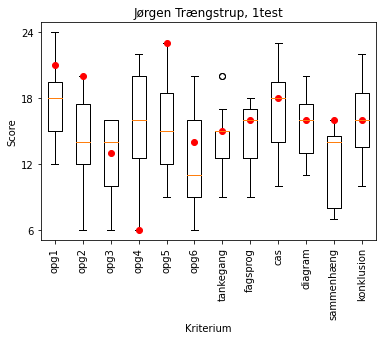

In [147]:
%matplotlib inline  
#def box_backdrop(klasse='1test', 
elev_navn='Jørgen Trængstrup'
from matplotlib import pyplot as plt
    # type(df.to_numpy > method > TypeError. Corrected by adding '()'
klasse = df.to_numpy()
# Elev needs reindexing to align on horizontal axis
elev_score = df_labelled.loc[elev_navn].to_numpy()
hor_ax =range(1,1+len(elev_score))
#fig = plt.figure()
#fig.subplots_adjust(top=0.8)
#ax1 = fig.add_subplot(211)
plt.ylabel('Score')
plt.xlabel('Kriterium')
plt.boxplot(klasse)
plt.title(elev_navn+', '+klasse_navn)
plt.xticks(hor_ax, df.columns.values, rotation='vertical')
plt.yticks([6*i for i in range(1,5)])
plt.plot(hor_ax, elev_score, 'or')
plt.show()

In [38]:
df.reset_index(drop=True, inplace=True)
df.to_numpy

<bound method DataFrame.to_numpy of     opg1  opg2  opg3  opg4  opg5  opg6  tankegang  fagsprog  cas  diagram  \
0     13    12     9    16    15     9         14        14   14       11   
1     15    13    14    15    15    19         15        17   17       15   
2     21    20    13     6    23    14         15        16   18       16   
3     16    14    10    13    14    11         13        13   16       16   
4     20    19    16    18    17    12         15        17   19       18   
5     18     6     6    11    10     6          9         9   11       11   
6     19    17    16    21    17    20         17        18   21       18   
7     24    11    16    19    10     8         12        12   20       16   
8     18    17    16    22    20     9         15        17   19       17   
9     19    18    15    22    23    18         20        18   23       20   
10    12    12    12    12     9    10         11        12   10       13   
11    13    12     9    16    15     9  

In [69]:
df_labelled.loc['Jørgen Trængstrup']

opg1          21
opg2          20
opg3          13
opg4           6
opg5          23
opg6          14
tankegang     15
fagsprog      16
cas           18
diagram       16
sammenhæng    16
konklusion    16
Name: Jørgen Trængstrup, dtype: int64

In [128]:
from boxplot.models import Elev, Klasse, AssesmentScore, Aflevering
Klasse.objects.get(navn='1test')

<Klasse: 1test (2020), Prøvens Gymnasium>

One approach to filter for **both** a school class, `Klasse`,
**and** a assignment, `Aflevering`, is to 
[chain filters](https://docs.djangoproject.com/en/3.1/topics/db/queries/#chaining-filters),
another is to derive from a `django.filters` class, like 
[this SO answer](https://stackoverflow.com/a/57270647/888033)
suggests.

In [125]:
selected_class = Klasse.objects.get(navn='1test')
(selected_class, selected_class.id)

(<Klasse: 1test (2020), Prøvens Gymnasium>, 3)

Assignment, `Aflevering` from the selected class **and** with the title related to 'covid'.

In [155]:
aflev1 = Aflevering.objects.filter(
    titel__icontains = 'covid'
)
aflev1

<QuerySet [<Aflevering: 'Model af CoVID19', 1test (2020/2) Prøvens Gymnasium, senest: 2020-11-10>]>

In the following cell, it looks like no assignments are submitted by students in class `1test`

In [157]:
aflev2 = Aflevering.objects.filter(
    klasse = selected_class.id
)
print((aflev2))

<QuerySet [<Aflevering: 'Model af CoVID19', 1test (2020/2) Prøvens Gymnasium, senest: 2020-11-10>]>


I therefore inspect the Aflevering model through the Django admin page, <http://localhost:8000/admin> (NB: Development server HTTP, not HTTP**S**). What I saw is shown as screendumps below.

![AssessmentScore inconsistent](AssessmentScore_inconsistent.png)
![Aflevering inconsistent](Aflevering_inconsistent.png)

Correcting this bootstrapped/demo `Aflevering` to be submitted by the class `1test`, 
the empty QuerySet gets populated as expected.

In [173]:
aflev = Aflevering.objects.filter(
    titel__icontains = 'covid'
).filter(
    klasse = selected_class.id
)
#print('Antal:', len(aflev))
if len(aflev) == 1:
    ass = AssesmentScore.objects.filter( aflevering = aflev[0].id )
    elev_liste = [elev.id for elev in ass]
    roster = Elev.objects.filter( pk__in=elev_liste)
else:
    print(len(aflev), "afleveringer lever op til kravet. Det er en fejl")
    exit
#print(ass)
print(len(ass))

24


In [172]:
selected_class = Klasse.objects.get(navn='1test')
selected_assignment = Aflevering.objects.get(titel__icontains='covid')

### Concluding the experiment: Function def

In [5]:
from boxplot.models import AssesmentScore, Aflevering, Elev, Klasse
from matplotlib import pyplot as plt
import pandas as pd

[Real Python on **understanding Matplotlib**](https://realpython.com/python-matplotlib-guide/)

NameError: name 'klasse_navn' is not defined

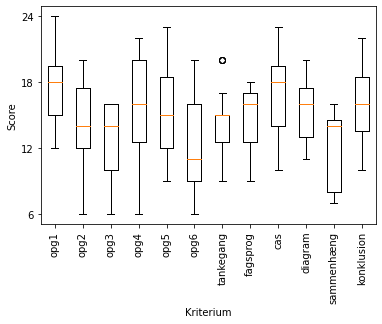

In [6]:
#%%timeit
#%matplotlib inline
def box_backdrop(klasse_navn, aflevering):
    """
    Creates a pyplot figure of 12 box-and-whiskers plots 
    with the Klasse >< Aflevering relation AssesmentScore.
    
    Performance: Django model data gathered, boxplot compiled in half a second.
    %%timeit gives: 
    449 ms ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
    Earlier profilings:
    779 ms ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
    - Consider cache
    And: 239 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
         Compiler time: 0.22 s
    
    Parameters
    klasse_navn
    aflevering (TODO: Implement filtering for submitted Assignment)
    
    Returns the pandas DataFrame of individual students used 
    (Model field fulde_navn as index).
    This DF can be used to overlay the generated plot with a point plot
    of each individual student.
    Suggestion: Store/cache "backdrop" plot and DF after first function call.
    Retrieve each time a feedback overlay of individual Student's performance
    needs to be plotted.
    """
    roster = Elev.objects.filter( klasse = Klasse.objects.get(navn=klasse_navn))
    # Add filter for `Aflevering`
    scores = AssesmentScore.objects.filter(elev__in=roster)
    klasse = Klasse.objects.get( navn = klasse_navn )
    elev_data = Elev.objects.filter( klasse = klasse.id )
    klasse_comprehension = [e.fulde_navn for e in elev_data]
    col_name_list = [f'opg{i}' for i in range(1,7)]
    col_name_list += [field.name for field in AssesmentScore._meta.fields][-6:]
    df_labelled = pd.DataFrame(
        data=scores.values(),
        columns=col_name_list,
        index=[s.elev.fulde_navn for s in scores]
    )
    # Conversion avoids TypeError: cannot perform reduce with flexible type
    klasse_data = df_labelled.to_numpy()
    # type(df.to_numpy > method > TypeError. Corrected by adding '()'
    boxplot = plt.figure()
    boxplot = plt.boxplot(klasse_data)
    boxplot = plt.axes
    boxplot = plt.ylabel('Score')
    boxplot = plt.xlabel('Kriterium')
    boxplot = plt.boxplot(klasse_data)
    #print(df_labelled.columns.values)
    boxplot = plt.xticks(
        range(1,1+df_labelled.shape[1]),
        df_labelled.columns.values,
        rotation='vertical'
    )
    boxplot = plt.yticks([6*i for i in range(1,5)])
    return df_labelled
df = box_backdrop('1test','covid')
import pickle
pickle.dump( plt.gcf(), open( "current_plot.p", "wb" ) )
pickle.dump( df, open( f"boxplot_klasse{klasse_navn}.p", "wb" ) )
plt.close()

[Wiki: Using Pickle](https://wiki.python.org/moin/UsingPickle)

## Overlay with arbitraty, individual student data (dot plot).

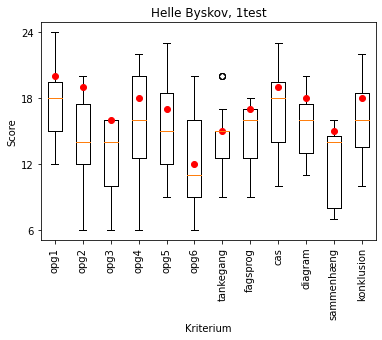

In [8]:
#%%timeit
### Function call time:
### 738 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### 831 ms ± 84.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
klasse_navn='1test'
#klasse_scores = box_backdrop(klasse_navn=klasse_navn)

### Pickle time:
### 487 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
### 476 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
with open( f"current_plot.p", "rb" ) as c:
    pickle.load( c )

with open( f"boxplot_klasse{klasse_navn}.p", "rb" ) as k:
    klasse_scores = pickle.load( k )

#elev_navn='Ida Himmark Mark'
#elev_navn='Emma Oue'
elev_navn='Helle Byskov'

plt.title(elev_navn+', '+klasse_navn)

### The row for this student
elev_score = klasse_scores.loc[elev_navn].to_numpy()
### Plot circled dots, 'o' in color RED, 'r'
plt.plot(range(1,1+klasse_scores.shape[1]), elev_score, 'or')

plt.show()